<a href="https://colab.research.google.com/github/VadimKhurs/BadComments/blob/main/bad_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
import numpy as np
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
df = pd.read_csv("data/labeled.csv")
df.shape

(14412, 2)

In [98]:
df["toxic"].value_counts()

,count
toxic,
0.0,9586
1.0,4826


In [99]:
df["toxic"] = df['toxic'].apply(int)

In [100]:
df["toxic"].value_counts()

,count
toxic,
0,9586
1,4826


In [101]:
for c in df[df["toxic"] == 1]["comment"].head(5):
  print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [102]:
for c in df[df["toxic"] == 0]["comment"].head(5):
  print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [103]:
train_df, test_df = train_test_split(df, test_size=500)

test_df.shape

(500, 2)

In [104]:
test_df["toxic"].value_counts()

,count
toxic,
0,315
1,185


In [105]:
sentence_example = df.iloc[1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

tokens

['Хохлы',
 ',',
 'это',
 'отдушина',
 'затюканого',
 'россиянина',
 ',',
 'мол',
 ',',
 'вон',
 ',',
 'а',
 'у',
 'хохлов',
 'еще',
 'хуже',
 '.',
 'Если',
 'бы',
 'хохлов',
 'не',
 'было',
 ',',
 'кисель',
 'их',
 'бы',
 'придумал',
 '.']

In [106]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
  tokens = word_tokenize(sentence, language="russian")
  tokens = [i for i in tokens if i not in string.punctuation]
  if remove_stop_words:
    tokens = [i for i in tokens if i not in russian_stop_words]
  tokens = [snowball.stem(i) for i in tokens]
  return tokens

tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [107]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))


In [108]:
features = vectorizer.fit_transform(train_df["comment"])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [109]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

In [118]:
pred_train = model.predict(features)

In [122]:
for i in np.where(pred_train == 0):
  print(i)
  print( train_df["comment"].iloc[i] )

[    4     6     7 ... 13905 13907 13910]
4038     Сейчас без камеры даже гриб-мухомор не сорвёшь...
8987         А как же радиоуправляемые машинки в клубах?\n
11374    Я понимаю) Это был крик души, за 6 месяцев в И...
11747    Плохо что тебя не интересуют особи женского по...
4794     Действительно век гаджетов, сейчас всё на бтар...
                               ...                        
7029     а движку на это пофигу? а то не хотелось бы на...
5516     Места замечательные, но лучше было когда никак...
5054     А сертификацией кто будет заниматься? придется...
11026    Вообще вполне логично, они не смогли её найти ...
7655     Тоже самое, даже в туалет лень идти, не говоря...
Name: comment, Length: 9999, dtype: object


In [125]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True)) ),
    ("model", LogisticRegression(random_state=0))
])

In [128]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7c4bf493c4a0>)),
                ('model', LogisticRegression(random_state=0))])

In [134]:
model_pipeline.predict(["Чел, в пидорахе мало военпреступников? ты ебанутый если ты аргументируешь войну, тем, что какой-то фашик где-то был, по такой логике вас нужно 1000 тысяч раз уничтожить. сколько говна вы сотворил"])

array([1])

In [137]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.9224806201550387

In [139]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6432432432432432

In [141]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:990: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


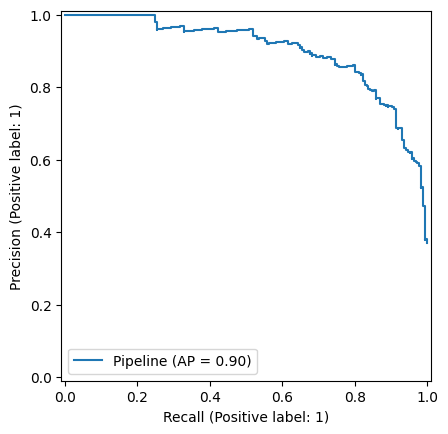

In [163]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [167]:
np.where(prec>0.95)

(array([397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
        410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
        423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487,
        488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]),)

In [166]:
np.where(prec>0.95)

(array([397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
        410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
        423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487,
        488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]),)

In [172]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[397])

0.96

In [175]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[397])

0.518918918918919

In [177]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True)) ),
    ("model",
      GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1., 10.]},
        verbose=4
      )
    )
])



In [178]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.697 total time=   0.5s
[CV 2/5] END .............................C=0.1;, score=0.696 total time=   1.0s
[CV 3/5] END .............................C=0.1;, score=0.699 total time=   0.9s
[CV 4/5] END .............................C=0.1;, score=0.697 total time=   1.5s
[CV 5/5] END .............................C=0.1;, score=0.701 total time=   0.7s
[CV 1/5] END .............................C=1.0;, score=0.842 total time=   2.3s
[CV 2/5] END .............................C=1.0;, score=0.848 total time=   0.9s
[CV 3/5] END .............................C=1.0;, score=0.845 total time=   0.7s
[CV 4/5] END .............................C=1.0;, score=0.848 total time=   0.9s
[CV 5/5] END .............................C=1.0;, score=0.842 total time=   0.7s
[CV 1/5] END ............................C=10.0;, score=0.859 total time=   1.5s
[CV 2/5] END ............................C=10.0;,

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7c4bf493c540>)),
                ('model',
                 GridSearchCV(estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1.0, 10.0]}, verbose=4))])

In [179]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True)) ),
    ("model", LogisticRegression(random_state=0))
])

In [180]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7c4bf424ca40>)),
                ('model', LogisticRegression(random_state=0))])

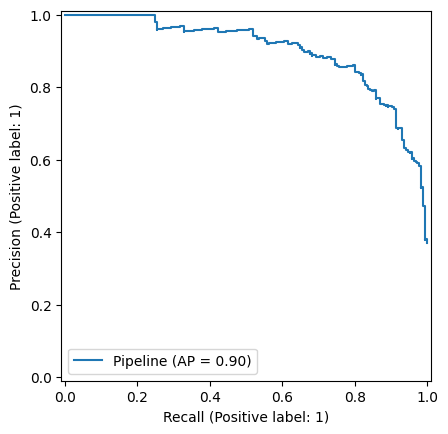

In [181]:
display = PrecisionRecallDisplay.from_estimator(estimator=model_pipeline_c_10, X=test_df["comment"], y=test_df["toxic"])

In [183]:
prec_c_10, \
rec_c_10, \
thresholds_c_10 = precision_recall_curve(
     y_true=test_df["toxic"],
     probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1]
)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:990: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(


In [186]:
np.where(prec_c_10 > 0.95)

(array([397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409,
        410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422,
        423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435,
        436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487,
        488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]),)

In [189]:
precision_score(
    y_true=test_df["toxic"],
    y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[397]
)

0.96

In [190]:
recall_score(
    y_true=test_df["toxic"],
    y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[397]
)

0.518918918918919